<a href="https://colab.research.google.com/github/CamilleKoczorowski/--dojo-clean-code--/blob/master/SVHN_MIWAE_notMIWAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIWAE and not-MIWAE on SVHN Dataset

This notebook implements the clipping experiment from the not-MIWAE paper (Section 4.3).
We emulate a clipping phenomenon where pixel values above a threshold are set to missing.

## 1. Imports and Setup

In [1]:
import os
# os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_probability as tfp
import keras
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat

# Check GPU availability
if tf.test.is_gpu_available():
    print("GPU is available!")
    print(f"GPU Device: {tf.test.gpu_device_name()}")
else:
    print("GPU is NOT available, using CPU.")

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available!
GPU Device: /device:GPU:0


## 2. Load SVHN Data

In [2]:
# Download SVHN dataset if not present
import urllib.request

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
test_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'

train_path = os.path.join(data_dir, 'train_32x32.mat')
test_path = os.path.join(data_dir, 'test_32x32.mat')

if not os.path.exists(train_path):
    print("Downloading SVHN training data...")
    urllib.request.urlretrieve(train_url, train_path)
    print("Done!")

if not os.path.exists(test_path):
    print("Downloading SVHN test data...")
    urllib.request.urlretrieve(test_url, test_path)
    print("Done!")

Done!
Done!


In [3]:
# Load and preprocess data
train_data = loadmat(train_path)
test_data = loadmat(test_path)

# Extract images and convert to grayscale, normalize to [0, 1]
def preprocess_svhn(data):
    X = data['X'].astype(np.float32)
    # Transpose from (32, 32, 3, N) to (N, 32, 32, 3)
    X = np.transpose(X, (3, 0, 1, 2))
    # Convert to grayscale
    X = np.mean(X, axis=-1, keepdims=True)
    # Normalize to [0, 1]
    X = X / 255.0
    return X

X_train = preprocess_svhn(train_data)
X_test = preprocess_svhn(test_data)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Use a subset for faster training (optional)
N_train = 10000  # Use 10k samples for training
N_test = 2000    # Use 2k samples for testing

np.random.seed(42)
train_idx = np.random.choice(len(X_train), N_train, replace=False)
test_idx = np.random.choice(len(X_test), N_test, replace=False)

X_train = X_train[train_idx]
X_test = X_test[test_idx]

print(f"Using {N_train} training samples and {N_test} test samples")

Training data shape: (73257, 32, 32, 1)
Test data shape: (26032, 32, 32, 1)
Using 10000 training samples and 2000 test samples


## 3. Introduce Missing Data (Clipping)

We use a self-masking mechanism identical to the paper:
$$P(s_{ij} = 1 | x_{ij}) = \frac{1}{1 + e^{-\text{logits}}}, \quad \text{logits} = W(x_{ij} - b)$$

where $W = -50$ and $b = 0.75$ (clipping point).

In [4]:
# Missing process parameters (from paper)
W_miss = -50.0
b_miss = 0.75

def introduce_missing(X, W, b):
    """Introduce MNAR missing data via clipping mechanism."""
    logits = W * (X - b)
    prob_observed = 1.0 / (1.0 + np.exp(-logits))
    S = np.random.binomial(1, prob_observed).astype(np.float32)

    # Create masked version (0 where missing)
    X_masked = X * S

    return X_masked, S

# Apply missing mechanism to training and test data
X_train_masked, S_train = introduce_missing(X_train, W_miss, b_miss)
X_test_masked, S_test = introduce_missing(X_test, W_miss, b_miss)

# Calculate missing rate
missing_rate_train = 1 - np.mean(S_train)
missing_rate_test = 1 - np.mean(S_test)
print(f"Training missing rate: {missing_rate_train:.2%}")
print(f"Test missing rate: {missing_rate_test:.2%}")

Training missing rate: 8.15%
Test missing rate: 11.31%


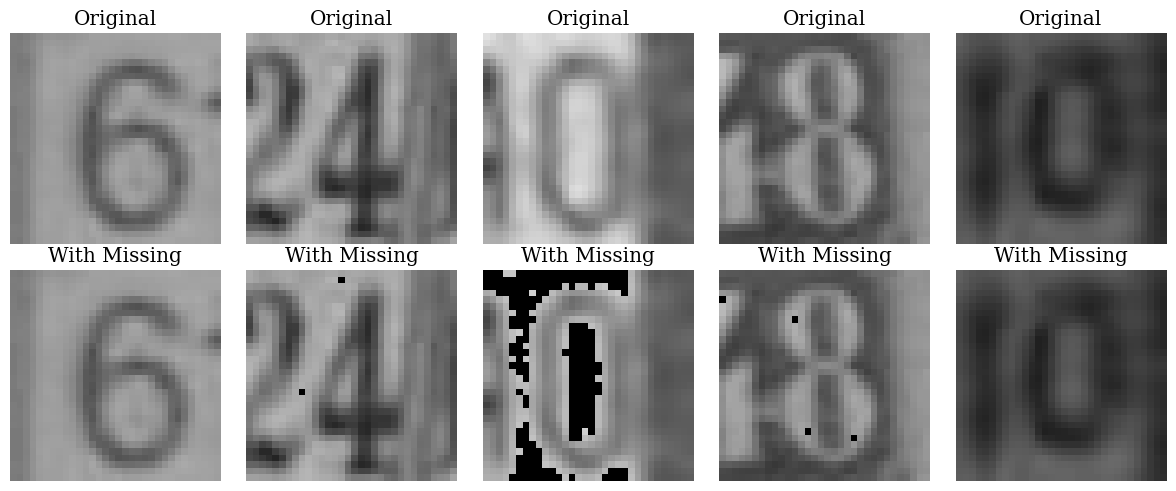

In [5]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow(X_train[i, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(X_train_masked[i, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title('With Missing')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

## 4. Model Settings

In [6]:
# Model hyperparameters
n_latent = 20
n_samples = 5  # Number of importance samples (K)
batch_size = 512
max_iter = 10000  # Reduce for faster experimentation
learning_rate = 0.001

# Data dimensions
img_height, img_width, img_channels = 32, 32, 1
D = img_height * img_width * img_channels

## 5. Build the Model

We build a convolutional VAE with:
- Encoder: Conv layers -> latent distribution
- Decoder: Dense + ConvTranspose layers -> reconstructed image
- Missing model: Logistic regression per pixel (for not-MIWAE)

In [7]:
print("Building computation graph...")
tf.reset_default_graph()

# Placeholders
with tf.variable_scope('input'):
    x_pl = tf.placeholder(tf.float32, [None, img_height, img_width, img_channels], 'x_pl')
    s_pl = tf.placeholder(tf.float32, [None, img_height, img_width, img_channels], 's_pl')
    n_pl = tf.placeholder(tf.int32, shape=(), name='n_pl')
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

Building computation graph...


In [8]:
# Encoder (Convolutional)
with tf.variable_scope('encoder'):
    # Input: [batch, 32, 32, 1]
    enc = keras.layers.Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu)(x_pl)
    # [batch, 16, 16, 64]
    enc = keras.layers.Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu)(enc)
    # [batch, 8, 8, 128]
    enc = keras.layers.Conv2D(256, 4, strides=2, padding='same', activation=tf.nn.relu)(enc)
    # [batch, 4, 4, 256]
    enc = keras.layers.Flatten()(enc)
    # [batch, 4096]

    q_mu = keras.layers.Dense(n_latent, activation=None, name='q_mu')(enc)
    q_logstd = keras.layers.Dense(n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10), name='q_logstd')(enc)

In [9]:
# Variational distribution and sampling
with tf.variable_scope('variational'):
    q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.exp(q_logstd))

    # Sample latent variables: [n_samples, batch, n_latent] -> [batch, n_samples, n_latent]
    l_z = q_z.sample(n_pl)
    l_z = tf.transpose(l_z, perm=[1, 0, 2])

In [10]:
# Decoder (Convolutional Transpose)
with tf.variable_scope('decoder'):
    # Reshape for convolutional layers
    batch_size_dynamic = tf.shape(l_z)[0]
    n_samples_dynamic = tf.shape(l_z)[1]

    # Flatten batch and samples: [batch * n_samples, n_latent]
    l_z_flat = tf.reshape(l_z, [-1, n_latent])

    dec = keras.layers.Dense(4 * 4 * 256, activation=tf.nn.relu)(l_z_flat)
    dec = tf.reshape(dec, [-1, 4, 4, 256])

    dec = keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu)(dec)
    # [batch * n_samples, 8, 8, 256]
    dec = keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu)(dec)
    # [batch * n_samples, 16, 16, 128]
    dec = keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu)(dec)
    # [batch * n_samples, 32, 32, 64]

    # Output mean (with sigmoid to bound [0, 1])
    mu_flat = keras.layers.Conv2DTranspose(1, 4, strides=1, padding='same', activation=tf.nn.sigmoid)(dec)
    # [batch * n_samples, 32, 32, 1]

    # Reshape back: [batch, n_samples, 32, 32, 1]
    mu = tf.reshape(mu_flat, [batch_size_dynamic, n_samples_dynamic, img_height, img_width, img_channels])

# Learned observation noise (lower bounded)
with tf.variable_scope('data_process'):
    logstd = tf.get_variable('logstd', shape=[], initializer=tf.constant_initializer(-2.0))
    obs_std = tf.maximum(tf.exp(logstd), 0.02)  # Lower bound ~0.02

In [11]:
# Observation model p(x|z)
with tf.variable_scope('observation'):
    p_x_given_z = tfp.distributions.Normal(loc=mu, scale=obs_std)

In [12]:
# Missing model p(s|x) for not-MIWAE
# We use the true missing mechanism (known)
with tf.variable_scope('missing_model'):
    # Mix observed data with samples from decoder for missing values
    # x_pl: [batch, 32, 32, 1], s_pl: [batch, 32, 32, 1]
    # mu: [batch, n_samples, 32, 32, 1]

    x_expanded = tf.expand_dims(x_pl, axis=1)  # [batch, 1, 32, 32, 1]
    s_expanded = tf.expand_dims(s_pl, axis=1)  # [batch, 1, 32, 32, 1]

    # Mix: use observed where available, sampled where missing
    l_out_mixed = mu * (1 - s_expanded) + x_expanded * s_expanded

    # True missing model parameters (from paper)
    W_missing = tf.constant(-50.0, dtype=tf.float32)
    b_missing = tf.constant(0.75, dtype=tf.float32)

    logits_missing = W_missing * (l_out_mixed - b_missing)
    p_s_given_x = tfp.distributions.Bernoulli(logits=logits_missing)

In [13]:
# Evaluate log-likelihoods
with tf.variable_scope('log_likelihoods'):
    # Log p(x^o | z) - only evaluate on observed pixels
    log_p_x_given_z = tf.reduce_sum(
        s_expanded * p_x_given_z.log_prob(x_expanded),
        axis=[2, 3, 4]  # Sum over spatial dimensions
    )  # [batch, n_samples]

    # Log q(z | x^o)
    q_z2 = tfp.distributions.Normal(
        loc=tf.expand_dims(q_z.loc, axis=1),
        scale=tf.expand_dims(q_z.scale, axis=1)
    )
    log_q_z_given_x = tf.reduce_sum(q_z2.log_prob(l_z), axis=-1)  # [batch, n_samples]

    # Log p(z) - standard normal prior
    prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
    log_p_z = tf.reduce_sum(prior.log_prob(l_z), axis=-1)  # [batch, n_samples]

    # Log p(s | x) for not-MIWAE
    log_p_s_given_x = tf.reduce_sum(
        p_s_given_x.log_prob(s_expanded),
        axis=[2, 3, 4]  # Sum over spatial dimensions
    )  # [batch, n_samples]

In [14]:
# MIWAE and not-MIWAE objectives
with tf.variable_scope('objectives'):
    # MIWAE: ignores missing mechanism
    l_w_miwae = log_p_x_given_z + log_p_z - log_q_z_given_x
    log_sum_w_miwae = tf.reduce_logsumexp(l_w_miwae, axis=1)
    log_avg_w_miwae = log_sum_w_miwae - tf.log(tf.cast(n_pl, tf.float32))
    MIWAE = tf.reduce_mean(log_avg_w_miwae)

    # not-MIWAE: includes missing mechanism
    l_w_notmiwae = log_p_x_given_z + log_p_s_given_x + log_p_z - log_q_z_given_x
    log_sum_w_notmiwae = tf.reduce_logsumexp(l_w_notmiwae, axis=1)
    log_avg_w_notmiwae = log_sum_w_notmiwae - tf.log(tf.cast(n_pl, tf.float32))
    notMIWAE = tf.reduce_mean(log_avg_w_notmiwae)

## 6. Training Setup

In [15]:
# Training operations
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

global_step = tf.Variable(initial_value=0, trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Get trainable variables
tvars = tf.trainable_variables()

# Separate training ops for MIWAE and not-MIWAE
loss_miwae = -MIWAE
loss_notmiwae = -notMIWAE

train_op_miwae = optimizer.minimize(loss_miwae, global_step=global_step, var_list=tvars)

# Reset optimizer for not-MIWAE
optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate)
global_step2 = tf.Variable(initial_value=0, trainable=False)
train_op_notmiwae = optimizer2.minimize(loss_notmiwae, global_step=global_step2, var_list=tvars)

## 7. Training Function

In [16]:
def train_model(sess, train_op, loss_op, model_name, X_data, S_data, max_iter, batch_size, n_samples):
    """Train either MIWAE or not-MIWAE."""
    N = len(X_data)
    batch_pointer = 0

    # Shuffle data
    perm = np.random.permutation(N)
    X_shuffled = X_data[perm]
    S_shuffled = S_data[perm]

    losses = []
    start = time.time()

    for i in range(max_iter):
        # Get batch
        x_batch = X_shuffled[batch_pointer:batch_pointer + batch_size]
        s_batch = S_shuffled[batch_pointer:batch_pointer + batch_size]

        # Train step
        _, _loss = sess.run(
            [train_op, loss_op],
            {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples, is_training: True}
        )

        losses.append(_loss)
        batch_pointer += batch_size

        # Reset batch pointer and reshuffle
        if batch_pointer > N - batch_size:
            batch_pointer = 0
            perm = np.random.permutation(N)
            X_shuffled = X_data[perm]
            S_shuffled = S_data[perm]

        # Print progress
        if i % 200 == 0:
            elapsed = time.time() - start
            avg_loss = np.mean(losses[-1000:]) if len(losses) >= 1000 else np.mean(losses)
            print(f"{model_name} - Iter {i}/{max_iter}, Loss: {avg_loss:.2f}, Time: {elapsed:.1f}s")
            start = time.time()

    return losses

## 8. Imputation Functions

In [17]:
def impute_miwae(sess, X_masked, S, L=1000):
    """Impute missing values using MIWAE (ignoring missing mechanism)."""
    N = len(X_masked)
    imputations = np.zeros_like(X_masked)

    for i in range(N):
        x = X_masked[i:i+1]
        s = S[i:i+1]

        # Get samples and weights
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: x, s_pl: s, n_pl: L, is_training: False}
        )

        # Compute importance weights (softmax)
        log_w = _log_p_x_given_z + _log_p_z - _log_q_z_given_x
        log_w = log_w - np.max(log_w)  # Numerical stability
        w = np.exp(log_w)
        w = w / np.sum(w)

        # Weighted average of reconstructions
        # _mu: [1, L, 32, 32, 1]
        imp = np.sum(_mu[0] * w[0, :, None, None, None], axis=0)

        # Mix with observed values
        imputations[i] = x[0] * s[0] + imp * (1 - s[0])

        if i % 200 == 0:
            print(f"MIWAE imputation: {i}/{N}")

    return imputations


def impute_notmiwae(sess, X_masked, S, L=1000):
    """Impute missing values using not-MIWAE (including missing mechanism)."""
    N = len(X_masked)
    imputations = np.zeros_like(X_masked)

    for i in range(N):
        x = X_masked[i:i+1]
        s = S[i:i+1]

        # Get samples and weights
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x, _log_p_s_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x],
            {x_pl: x, s_pl: s, n_pl: L, is_training: False}
        )

        # Compute importance weights including missing model
        log_w = _log_p_x_given_z + _log_p_s_given_x + _log_p_z - _log_q_z_given_x
        log_w = log_w - np.max(log_w)
        w = np.exp(log_w)
        w = w / np.sum(w)

        # Weighted average
        imp = np.sum(_mu[0] * w[0, :, None, None, None], axis=0)

        # Mix with observed
        imputations[i] = x[0] * s[0] + imp * (1 - s[0])

        if i % 200 == 0:
            print(f"not-MIWAE imputation: {i}/{N}")

    return imputations

## 9. Train MIWAE

In [18]:
#TRAINING WITH GPU T4
## Initialize session and train MIWAE
#sess_miwae = tf.Session(config=config)
#sess_miwae.run(tf.global_variables_initializer())
#
#print("Training MIWAE...")
#losses_miwae = train_model(
#    sess_miwae, train_op_miwae, loss_miwae, "MIWAE",
#    X_train_masked, S_train, max_iter, batch_size, n_samples
#)
#print("MIWAE training complete!")

Training MIWAE...
MIWAE - Iter 0/50000, Loss: -175.60, Time: 7.6s
MIWAE - Iter 1000/50000, Loss: -997.53, Time: 80.6s
MIWAE - Iter 2000/50000, Loss: -1324.48, Time: 80.7s
MIWAE - Iter 3000/50000, Loss: -1432.46, Time: 80.6s
MIWAE - Iter 4000/50000, Loss: -1552.30, Time: 80.4s
MIWAE - Iter 5000/50000, Loss: -1654.38, Time: 80.4s
MIWAE - Iter 6000/50000, Loss: -1739.93, Time: 80.3s
MIWAE - Iter 7000/50000, Loss: -1802.97, Time: 80.4s
MIWAE - Iter 8000/50000, Loss: -1856.01, Time: 80.5s
MIWAE - Iter 9000/50000, Loss: -1901.83, Time: 80.3s
MIWAE - Iter 10000/50000, Loss: -1934.73, Time: 80.3s
MIWAE - Iter 11000/50000, Loss: -1968.07, Time: 80.3s
MIWAE - Iter 12000/50000, Loss: -1997.52, Time: 80.2s


KeyboardInterrupt: 

In [18]:
#TRAINING WITH GPU L4
# Initialize session and train MIWAE
sess_miwae = tf.Session(config=config)
sess_miwae.run(tf.global_variables_initializer())

print("Training MIWAE...")
losses_miwae = train_model(
    sess_miwae, train_op_miwae, loss_miwae, "MIWAE",
    X_train_masked, S_train, max_iter, batch_size, n_samples
)
print("MIWAE training complete!")

Training MIWAE...
MIWAE - Iter 0/10000, Loss: -154.86, Time: 11.0s
MIWAE - Iter 200/10000, Loss: -734.94, Time: 29.4s
MIWAE - Iter 400/10000, Loss: -847.07, Time: 29.6s
MIWAE - Iter 600/10000, Loss: -934.91, Time: 29.8s
MIWAE - Iter 800/10000, Loss: -1000.62, Time: 30.0s
MIWAE - Iter 1000/10000, Loss: -1057.98, Time: 30.1s
MIWAE - Iter 1200/10000, Loss: -1181.18, Time: 30.1s
MIWAE - Iter 1400/10000, Loss: -1280.16, Time: 30.1s
MIWAE - Iter 1600/10000, Loss: -1368.17, Time: 30.2s
MIWAE - Iter 1800/10000, Loss: -1423.92, Time: 30.0s
MIWAE - Iter 2000/10000, Loss: -1488.64, Time: 30.1s
MIWAE - Iter 2200/10000, Loss: -1552.32, Time: 30.1s
MIWAE - Iter 2400/10000, Loss: -1596.03, Time: 30.1s
MIWAE - Iter 2600/10000, Loss: -1649.28, Time: 30.1s
MIWAE - Iter 2800/10000, Loss: -1718.01, Time: 30.1s
MIWAE - Iter 3000/10000, Loss: -1764.47, Time: 30.0s
MIWAE - Iter 3200/10000, Loss: -1784.03, Time: 30.0s
MIWAE - Iter 3400/10000, Loss: -1841.58, Time: 30.1s
MIWAE - Iter 3600/10000, Loss: -1853.90

In [19]:
# Impute with MIWAE
print("\nComputing MIWAE imputations...")
imputations_miwae = impute_miwae(sess_miwae, X_test_masked, S_test, L=1000)


Computing MIWAE imputations...
MIWAE imputation: 0/2000
MIWAE imputation: 200/2000
MIWAE imputation: 400/2000
MIWAE imputation: 600/2000
MIWAE imputation: 800/2000
MIWAE imputation: 1000/2000
MIWAE imputation: 1200/2000
MIWAE imputation: 1400/2000
MIWAE imputation: 1600/2000
MIWAE imputation: 1800/2000


In [20]:
# Calculate MIWAE RMSE
rmse_miwae = np.sqrt(
    np.sum((X_test - imputations_miwae) ** 2 * (1 - S_test)) / np.sum(1 - S_test)
)
print(f"MIWAE Imputation RMSE: {rmse_miwae:.5f}")

# Constant imputation baseline (impute with 1's since values > 0.75 are clipped)
constant_imp = X_test_masked + (1 - S_test) * 1.0
rmse_constant = np.sqrt(
    np.sum((X_test - constant_imp) ** 2 * (1 - S_test)) / np.sum(1 - S_test)
)
print(f"Constant (1's) Imputation RMSE: {rmse_constant:.5f}")

MIWAE Imputation RMSE: 0.14374
Constant (1's) Imputation RMSE: 0.16664


## 10. Train not-MIWAE

In [21]:
# Initialize new session for not-MIWAE
sess_notmiwae = tf.Session(config=config)
sess_notmiwae.run(tf.global_variables_initializer())

print("Training not-MIWAE...")
losses_notmiwae = train_model(
    sess_notmiwae, train_op_notmiwae, loss_notmiwae, "not-MIWAE",
    X_train_masked, S_train, max_iter, batch_size, n_samples
)
print("not-MIWAE training complete!")

Training not-MIWAE...
not-MIWAE - Iter 0/10000, Loss: 857.76, Time: 2.6s
not-MIWAE - Iter 200/10000, Loss: -394.47, Time: 30.2s
not-MIWAE - Iter 400/10000, Loss: -612.52, Time: 30.4s
not-MIWAE - Iter 600/10000, Loss: -720.01, Time: 30.3s
not-MIWAE - Iter 800/10000, Loss: -806.89, Time: 30.4s
not-MIWAE - Iter 1000/10000, Loss: -887.15, Time: 30.4s
not-MIWAE - Iter 1200/10000, Loss: -1064.98, Time: 30.4s
not-MIWAE - Iter 1400/10000, Loss: -1173.89, Time: 30.4s
not-MIWAE - Iter 1600/10000, Loss: -1274.97, Time: 30.4s
not-MIWAE - Iter 1800/10000, Loss: -1377.77, Time: 30.4s
not-MIWAE - Iter 2000/10000, Loss: -1432.23, Time: 30.3s
not-MIWAE - Iter 2200/10000, Loss: -1513.78, Time: 30.4s
not-MIWAE - Iter 2400/10000, Loss: -1547.43, Time: 30.3s
not-MIWAE - Iter 2600/10000, Loss: -1615.58, Time: 30.4s
not-MIWAE - Iter 2800/10000, Loss: -1650.52, Time: 30.4s
not-MIWAE - Iter 3000/10000, Loss: -1729.75, Time: 30.4s
not-MIWAE - Iter 3200/10000, Loss: -1682.02, Time: 30.2s
not-MIWAE - Iter 3400/10

In [22]:
# Impute with not-MIWAE
print("\nComputing not-MIWAE imputations...")
imputations_notmiwae = impute_notmiwae(sess_notmiwae, X_test_masked, S_test, L=1000)


Computing not-MIWAE imputations...
not-MIWAE imputation: 0/2000
not-MIWAE imputation: 200/2000
not-MIWAE imputation: 400/2000
not-MIWAE imputation: 600/2000
not-MIWAE imputation: 800/2000
not-MIWAE imputation: 1000/2000
not-MIWAE imputation: 1200/2000
not-MIWAE imputation: 1400/2000
not-MIWAE imputation: 1600/2000
not-MIWAE imputation: 1800/2000


In [23]:
# Calculate not-MIWAE RMSE
rmse_notmiwae = np.sqrt(
    np.sum((X_test - imputations_notmiwae) ** 2 * (1 - S_test)) / np.sum(1 - S_test)
)
print(f"not-MIWAE Imputation RMSE: {rmse_notmiwae:.5f}")

not-MIWAE Imputation RMSE: 0.10662


## 11. Results and Visualization

In [24]:
# Summary of results
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"Constant Imputation RMSE: {rmse_constant:.5f}")
print(f"MIWAE Imputation RMSE:    {rmse_miwae:.5f}")
print(f"not-MIWAE Imputation RMSE: {rmse_notmiwae:.5f}")
print("="*50)


RESULTS SUMMARY
Constant Imputation RMSE: 0.16664
MIWAE Imputation RMSE:    0.14374
not-MIWAE Imputation RMSE: 0.10662


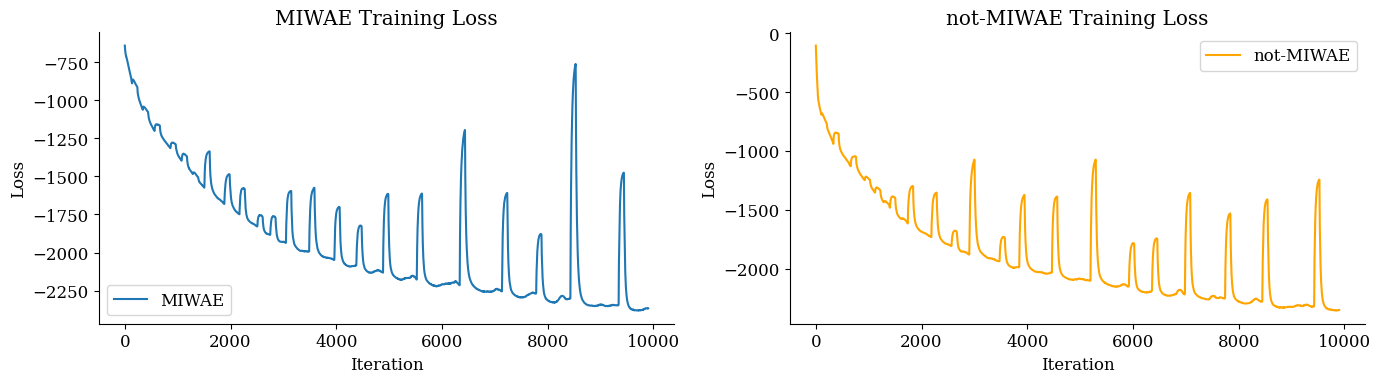

In [25]:
# Plot training losses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Smooth losses for visualization
window = 100
losses_miwae_smooth = np.convolve(losses_miwae, np.ones(window)/window, mode='valid')
losses_notmiwae_smooth = np.convolve(losses_notmiwae, np.ones(window)/window, mode='valid')

ax1.plot(losses_miwae_smooth, label='MIWAE')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('MIWAE Training Loss')
ax1.legend()

ax2.plot(losses_notmiwae_smooth, label='not-MIWAE', color='orange')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('not-MIWAE Training Loss')
ax2.legend()

plt.tight_layout()
plt.show()

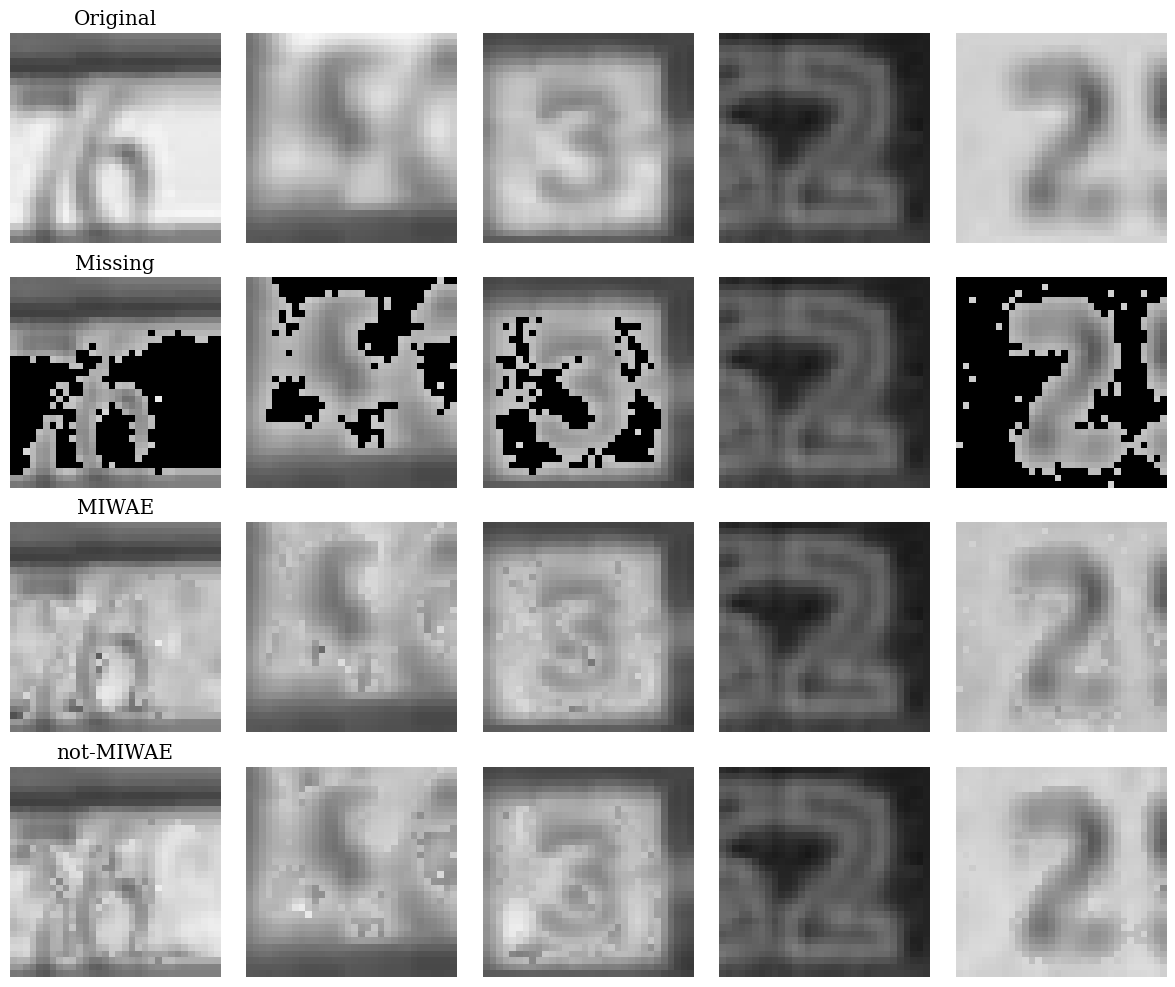

In [26]:
# Visualize imputations
n_examples = 5
fig, axes = plt.subplots(4, n_examples, figsize=(12, 10))

for i in range(n_examples):
    idx = i * 50  # Spread out examples

    # Original
    axes[0, i].imshow(X_test[idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title('Original' if i == 0 else '')
    axes[0, i].axis('off')

    # With missing
    axes[1, i].imshow(X_test_masked[idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title('Missing' if i == 0 else '')
    axes[1, i].axis('off')

    # MIWAE imputation
    axes[2, i].imshow(imputations_miwae[idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title('MIWAE' if i == 0 else '')
    axes[2, i].axis('off')

    # not-MIWAE imputation
    axes[3, i].imshow(imputations_notmiwae[idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[3, i].set_title('not-MIWAE' if i == 0 else '')
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig('svhn_imputations.png', dpi=150, bbox_inches='tight')
plt.show()

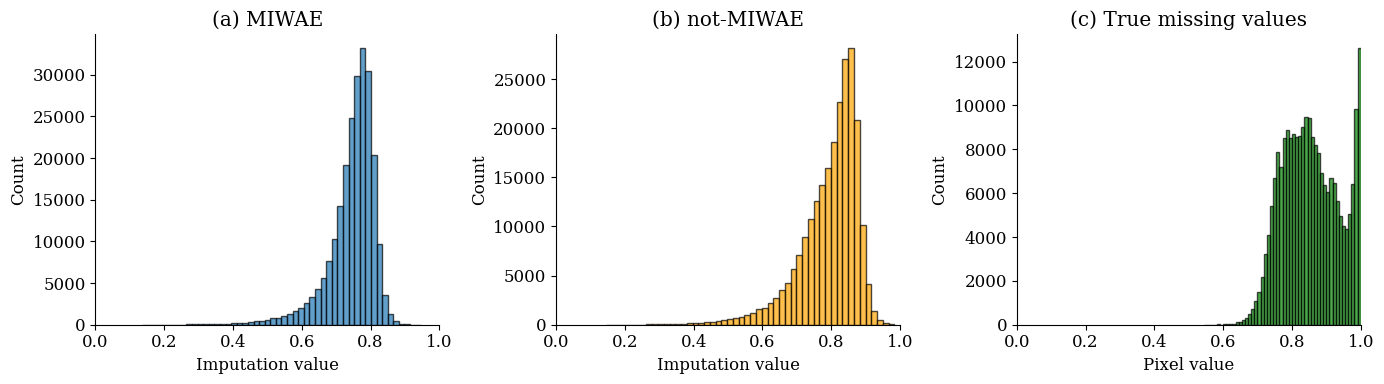

In [27]:
# Histograms of imputed values (as in paper Figure 2)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Get only the imputed (missing) values
missing_mask = (1 - S_test).astype(bool)

miwae_imputed_vals = imputations_miwae[missing_mask]
notmiwae_imputed_vals = imputations_notmiwae[missing_mask]
true_missing_vals = X_test[missing_mask]

axes[0].hist(miwae_imputed_vals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Imputation value')
axes[0].set_ylabel('Count')
axes[0].set_title('(a) MIWAE')
axes[0].set_xlim([0, 1])

axes[1].hist(notmiwae_imputed_vals, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Imputation value')
axes[1].set_ylabel('Count')
axes[1].set_title('(b) not-MIWAE')
axes[1].set_xlim([0, 1])

axes[2].hist(true_missing_vals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('Pixel value')
axes[2].set_ylabel('Count')
axes[2].set_title('(c) True missing values')
axes[2].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('svhn_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
# Print statistics about imputations
print("\nImputation Statistics:")
print(f"True missing values - Mean: {np.mean(true_missing_vals):.3f}, Std: {np.std(true_missing_vals):.3f}")
print(f"MIWAE imputations   - Mean: {np.mean(miwae_imputed_vals):.3f}, Std: {np.std(miwae_imputed_vals):.3f}")
print(f"not-MIWAE imputations - Mean: {np.mean(notmiwae_imputed_vals):.3f}, Std: {np.std(notmiwae_imputed_vals):.3f}")

# Percentage above clipping threshold
print(f"\nPercentage above clipping threshold (0.75):")
print(f"True missing values:  {100*np.mean(true_missing_vals > 0.75):.1f}%")
print(f"MIWAE imputations:    {100*np.mean(miwae_imputed_vals > 0.75):.1f}%")
print(f"not-MIWAE imputations: {100*np.mean(notmiwae_imputed_vals > 0.75):.1f}%")


Imputation Statistics:
True missing values - Mean: 0.855, Std: 0.083
MIWAE imputations   - Mean: 0.744, Std: 0.070
not-MIWAE imputations - Mean: 0.793, Std: 0.086

Percentage above clipping threshold (0.75):
True missing values:  90.3%
MIWAE imputations:    57.3%
not-MIWAE imputations: 75.9%


## 12. Close Sessions

In [29]:
sess_miwae.close()
sess_notmiwae.close()
print("Sessions closed.")

Sessions closed.
